In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Synthetic data

In [12]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(12,8))
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    
    dataset = tf.data.Dataset.from_tensor_slices(series) #Creates a Dataset whose elements are slices of the given tensors.
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True) #Create the windows
    dataset = dataset.flat_map(lambda x: x.batch(window_size+1)) #Flat the data out
    dataset = dataset.shuffle(shuffle_buffer) #Shuffles the data
    dataset = dataset.map(lambda x: (x[:-1],x[-1])) #Separates xs and ys
    dataset = dataset.batch(batch_size).prefetch(1) #Create batches
    
    return dataset

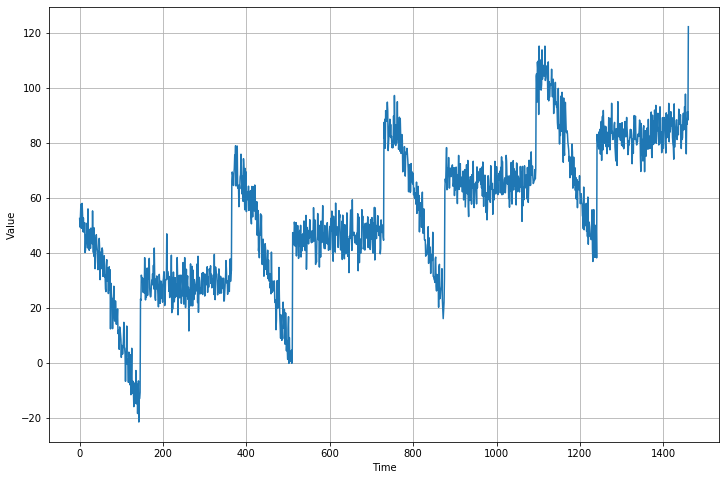

In [13]:
plot_series(time, series)

### Create dataset

In [15]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)

### Model

In [18]:
lr = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([lr])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

### Predict

<Figure size 720x432 with 0 Axes>

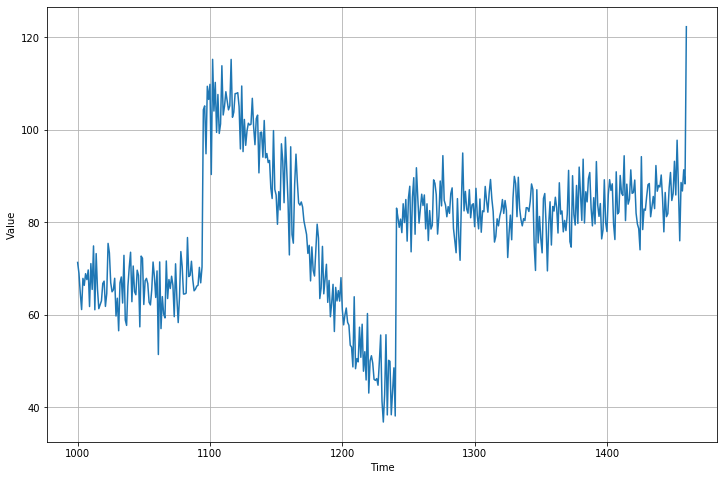

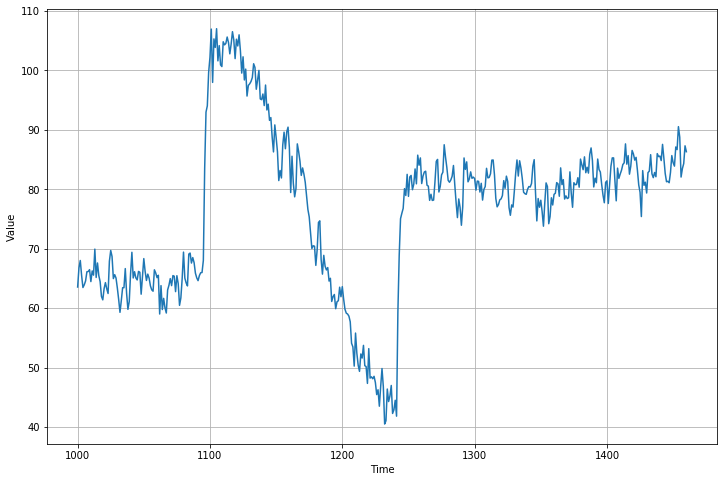

In [19]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)